<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Check for GPU


zsh:1: command not found: nvidia-smi


In [ ]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

1.10.0+cu111


'cuda'

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [52]:
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.MNIST(
    root="data", # where to download data to?
    train=False, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

In [56]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 6. Visualize at least 5 different samples of the MNIST training dataset.

torch.Size([1, 28, 28])

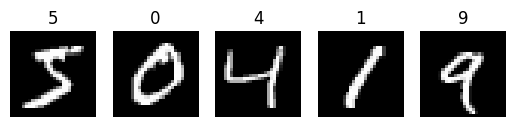

In [21]:
# Visualize 5 different images from the training dataset
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(train_data[i][0].squeeze(), cmap="gray") # squeeze removes the color channel
    ax[i].set_title(train_data[i][1])
    ax[i].axis("off")
    

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [53]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [61]:
class TinyVGGModel(nn.Module):
    def __init__(self, num_channel, hidden_units, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channel, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*hidden_units, out_features=num_classes)  
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x
    
num_classes = len(train_data.classes)    
model = TinyVGGModel(num_channel=1, hidden_units=64, num_classes=num_classes)
model.to(device)

TinyVGGModel(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [62]:
import torchmetrics
epochs = 5
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
accuracy_train = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
accuracy_test = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
# Training loop
for epoch in range(epochs):
    print(f"######### EPOCH {epoch} #########")
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(X)
        loss_train = loss_fn(y_pred, y)
        accuracy_train.update(y_pred, y)
        loss_train.backward()
        optim.step()
    train_acc = accuracy_train.compute()  
    print(f"Train loss: {loss_train.item()}, Train accuracy: {train_acc}")
    accuracy_train.reset()
    
    # Validation loop
    with torch.inference_mode():
        model.eval()
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            y_pred_test = model(X)
            loss_test = loss_fn(y_pred_test, y)
            accuracy_test.update(y_pred_test, y)
    test_acc = accuracy_test.compute()
    print(f"Test loss: {loss_test.item()}, Test accuracy: {test_acc}")
    accuracy_test.reset()
                

######### EPOCH 0 #########
Train loss: 0.2120211124420166, Train accuracy: 0.7516000270843506
Test loss: 0.008156152442097664, Test accuracy: 0.9690999984741211
######### EPOCH 1 #########
Train loss: 0.03499551862478256, Train accuracy: 0.9692333340644836
Test loss: 0.007329909596592188, Test accuracy: 0.9779999852180481
######### EPOCH 2 #########
Train loss: 0.039966024458408356, Train accuracy: 0.977733314037323
Test loss: 0.0015384554862976074, Test accuracy: 0.983299970626831
######### EPOCH 3 #########
Train loss: 0.03894808143377304, Train accuracy: 0.9824833273887634
Test loss: 0.00010656388622010127, Test accuracy: 0.9835000038146973
######### EPOCH 4 #########
Train loss: 0.020146798342466354, Train accuracy: 0.9849833250045776
Test loss: 0.00033999382867477834, Test accuracy: 0.9869999885559082


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

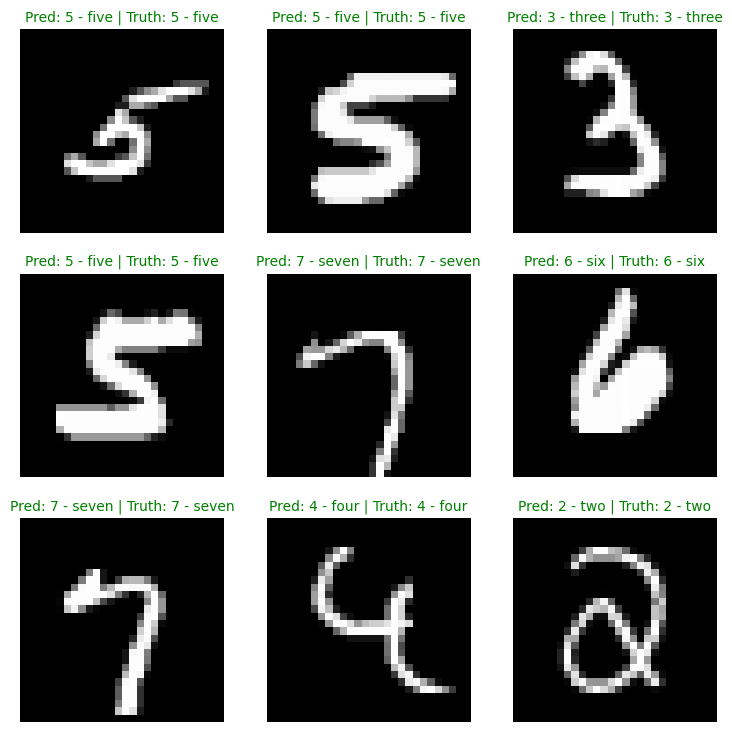

In [65]:
def make_predictions(model: torch.nn.Module, data: list, device: str = device):
    pred_classes = []
    model.eval()
    for sample in data:
        # Move data to device
        sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
        # Why we need to add an extra dimension? Because the model expects a 4-dimensional tensor (batch_size, color_channels, height, width)

        # Forward pass (model outputs raw logit)
        pred_logit = model(sample)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

        # Get pred_prob off GPU for further calculations
        #pred_probs.append(torch.stack(pred_prob.cpu()))
      
        # Get predicted class
        #pred_class = pred_prob.argmax(dim=0)
        pred_classes.append(pred_prob.argmax(dim=0).cpu().item())
    return pred_classes    


# Get random 9 samples from test_data in a list
torch.manual_seed(42)
test_sample, test_labels = zip(*[(test_data[i][0], test_data[i][1]) for i in torch.randint(0, len(test_data), (9,))])

# Make predictions
preds = make_predictions(model, test_sample, device)
class_names = test_data.classes
# Get the label names from preds
pred_classes = [class_names[pred] for pred in preds]
true_classes = [class_names[label] for label in test_labels]

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_sample):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_class = pred_classes[i]
  true_class = true_classes[i]
    
  # Create the title text of the plot
  title_text = f"Pred: {pred_class} | Truth: {true_class}"
  
  # Check for equality and change title colour accordingly
  if pred_class == true_class:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [66]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

/Users/aliyilmaz/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Making predictions: 100%|██████████| 313/313 [00:01<00:00, 279.83it/s]


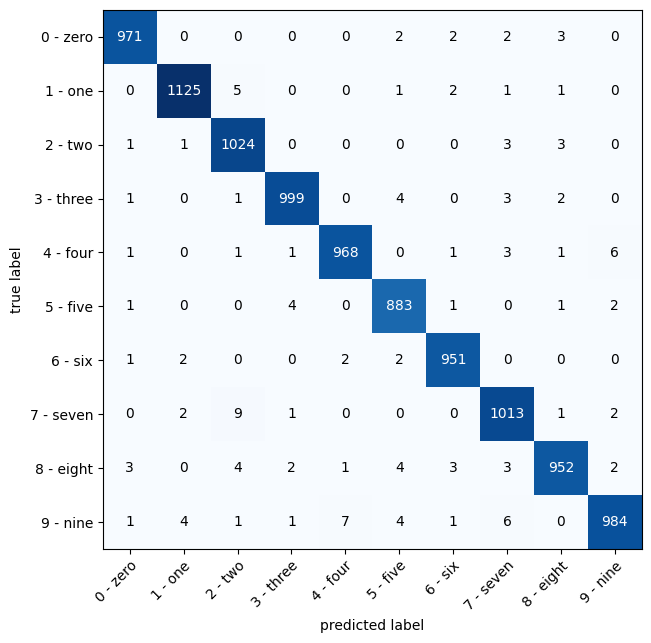

In [67]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);